In [1]:
import tensorflow as tf
from tensorflow import keras


batch_size = 32
img_height = 224
img_width = 224
validation_split = 0.2
seed = 4266

data_dir = "./data/train/"

train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="training",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=validation_split,
  subset="validation",
  seed=seed,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5232 files belonging to 2 classes.
Using 4186 files for training.
Found 5232 files belonging to 2 classes.
Using 1046 files for validation.


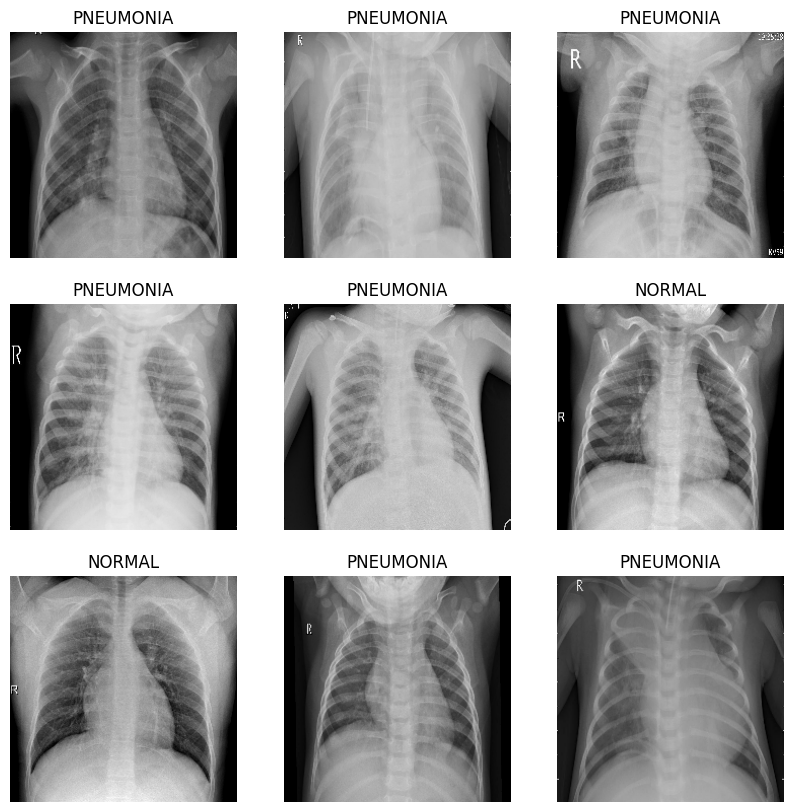

In [3]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_dataset.class_names[labels[i]])
    plt.axis("off")

In [9]:
from keras.applications.densenet import DenseNet121


# Load the DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze convolutional base
base_model.trainable = False

# Add classification head
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch) # Neck
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)  # Head

# Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

# Build model
inputs = tf.keras.Input(shape=(img_height, img_width, 3))
x = data_augmentation(inputs)
x = keras.applications.densenet.preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compile model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.TruePositives(),
                       tf.keras.metrics.FalsePositives(),
                       tf.keras.metrics.TrueNegatives(),
                       tf.keras.metrics.FalseNegatives(),
                       tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall()])

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        703750

In [10]:
import json

# Callback to save the model weights
checkpoint_filepath = "./checkpoints/densenet121/densenet121_{epoch:02d}_{val_loss:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_freq='epoch',
    save_weights_only=True)

# Train model
epochs = 10
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=val_dataset,
                    callbacks=[model_checkpoint_callback])

# Save history
json.dump(history.history, open("./checkpoints/densenet121/history.json", 'w'))

Epoch 1/10
131/131 [==============================] - 242s 2s/step - loss: 0.6134 - binary_accuracy: 0.6077 - true_positives_1: 1975.0000 - false_positives_1: 500.0000 - true_negatives_1: 569.0000 - false_negatives_1: 1142.0000 - precision_1: 0.7980 - recall_1: 0.6336 - val_loss: 0.5390 - val_binary_accuracy: 0.7361 - val_true_positives_1: 748.0000 - val_false_positives_1: 258.0000 - val_true_negatives_1: 22.0000 - val_false_negatives_1: 18.0000 - val_precision_1: 0.7435 - val_recall_1: 0.9765
Epoch 2/10
131/131 [==============================] - 230s 2s/step - loss: 0.5114 - binary_accuracy: 0.7339 - true_positives_1: 2627.0000 - false_positives_1: 624.0000 - true_negatives_1: 445.0000 - false_negatives_1: 490.0000 - precision_1: 0.8081 - recall_1: 0.8428 - val_loss: 0.4685 - val_binary_accuracy: 0.7725 - val_true_positives_1: 741.0000 - val_false_positives_1: 213.0000 - val_true_negatives_1: 67.0000 - val_false_negatives_1: 25.0000 - val_precision_1: 0.7767 - val_recall_1: 0.9674
Epo